Basic analyses of behavior in the FHT task. 

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy

# 1. Load and prep behavioral data

In [2]:
behav_path = os.getcwd() + '/ProcessedData/AllData.csv' # this expects ProcessedData to be in the analysis repo
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.12700,1
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.08580,2
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,NaN,NaN,0.0,NaN,NaN,1.24420,3
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,NaN,NaN,1.0,NaN,NaN,0.47509,4
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.88090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.61252,16
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.89898,17
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.59331,18
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.52019,19


In [3]:
subj_id = 39
block = 10
trial = 7
sub = behav_data.loc[behav_data['Subj'] == subj_id]
sub = sub.loc[sub['Trial'] == (block-1)*40 + trial]
sub[['Chosen1', 'Chosen2', 'Chosen3', 'Feat']]

,Chosen1,Chosen2,Chosen3,Feat
5566,3.0,5.0,8.0,5


# 2. Plot general learning and accuracy

## 2a. Plot general learning curve

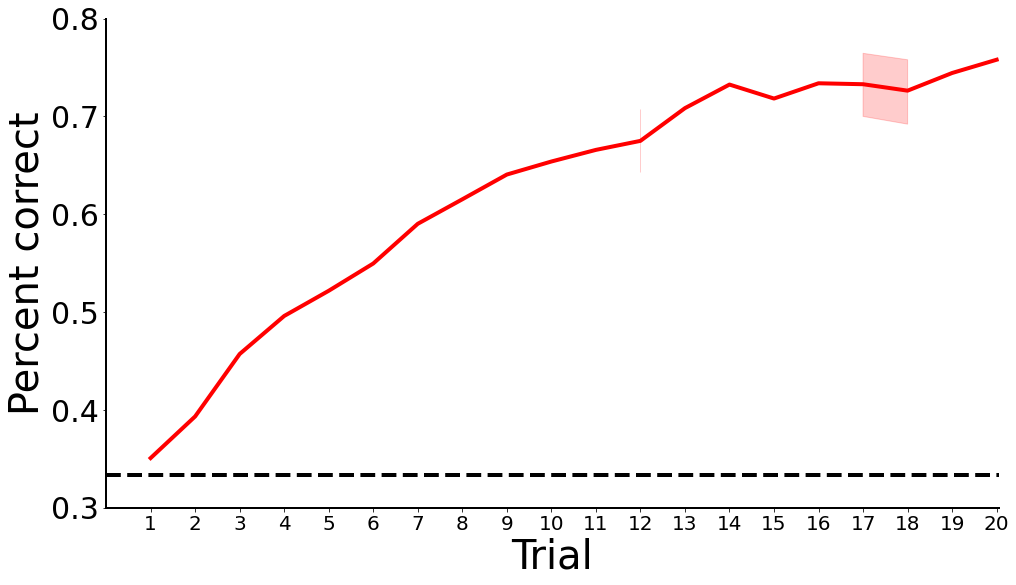

In [4]:
df = pd.melt(behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='red')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 2b. Plot general number correct in last 6

In [5]:
def getLastSixGames(behav_data, game_length):
    last_6 = np.arange(game_length-6,game_length)+1

    df_last_6 = behav_data.loc[behav_data['WithinGameTrial'].isin(last_6)]
    df_last_6 = df_last_6.reset_index(drop=True)
    df_last_6 = df_last_6[['Subj','Game','WithinGameTrial','Correct']]

    ## Sum corrects in last 6 within game.
    df_last_6 = df_last_6.groupby(['Subj','Game'])['Correct'].sum().reset_index()

    ## Count and normalize by number of games.
    df_last_6 = df_last_6.groupby(['Subj','Correct']).count().unstack(fill_value=0).stack().reset_index()
    df_last_6['Game'] = df_last_6['Game'] / n_games
    
    return df_last_6


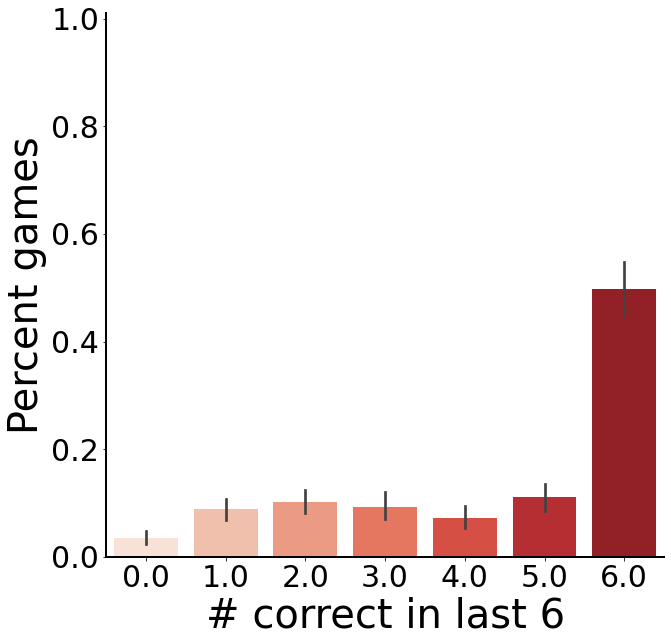

In [6]:
df_last_6 = getLastSixGames(behav_data, game_length)
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="Correct", y="Game", data=df_last_6, palette="Reds",ci=95);
sns.despine()
ax.set_ylim([0,1.01])
xl = ax.set_xlabel('# correct in last 6',fontsize = 40);
yl = ax.set_ylabel('Percent games',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)

In [7]:
# grab the percentage of games per subject in which they had 5 or 6 correct in the last 6 trials
percent_last_six_learned = pd.DataFrame(data=df_last_6.loc[df_last_6['Correct'] > 4].reset_index(drop=True).groupby('Subj')['Game'].sum()).reset_index()

In [8]:
# if the percentage of games that the subject had 5 or 6 correct in the last 6 trials is above 65%, then the game is learned
learned = percent_last_six_learned.loc[percent_last_six_learned['Game'] >= 0.65].reset_index(drop=True)
learned_sub_ids = learned.Subj.to_numpy()
notlearned = percent_last_six_learned.loc[percent_last_six_learned['Game'] < 0.65].reset_index(drop=True)
notlearned_sub_ids = notlearned.Subj.to_numpy()
learned_df = behav_data.copy()
notlearned_df = behav_data.copy()

# store learned information in new dataframe and in big dataframe
for subj in learned_sub_ids:
    notlearned_df = notlearned_df[notlearned_df.Subj != subj]
    behav_data.loc[behav_data['Subj'] == subj,'LearnedFeat'] = True
for subj in notlearned_sub_ids:
    learned_df = learned_df[learned_df.Subj != subj]
    behav_data.loc[behav_data['Subj'] == subj,'LearnedFeat'] = False

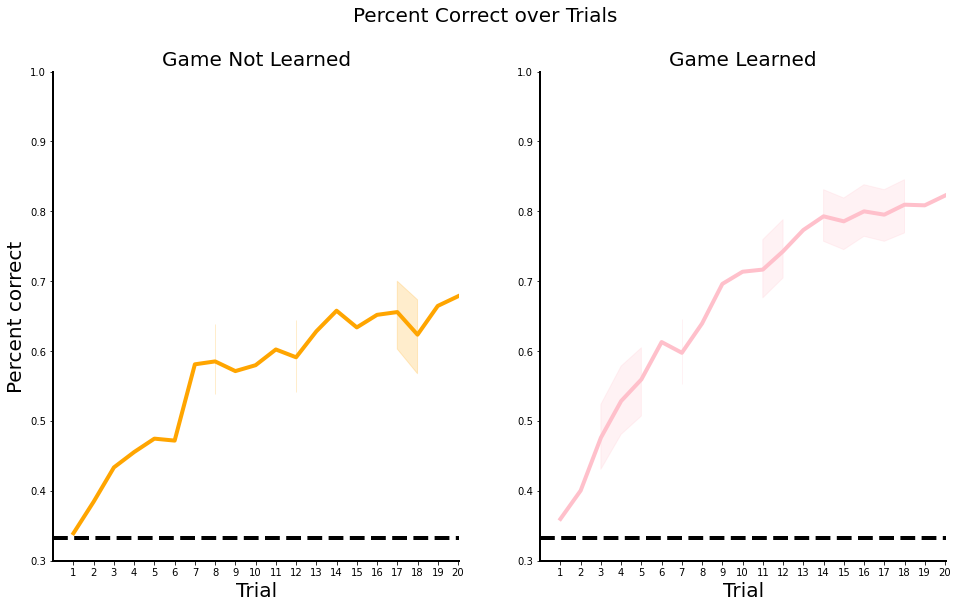

In [9]:
df_learned = pd.melt(learned_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_notlearned = pd.melt(notlearned_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Percent Correct over Trials',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)
ax1.axhline(y=1/3, color='k', lw=4, linestyle='--');
ax2.axhline(y=1/3, color='k', lw=4, linestyle='--');

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_notlearned, lw=4, legend=False, color='orange')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_learned, lw=4, legend=False, color='pink')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0.3,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0.3, 1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
# plt.xticks(fontsize=20);
# plt.yticks(fontsize=20);

# 3. Plot learning curves by age

In [10]:
# import agemap
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/'
age_df = pd.read_csv(raw_data_dir + 'SubDemographics.csv').dropna()
age_df['Subj_id'] = age_df['Subj_id'].astype(int)
ageMap = age_df[['Age','Subj_id']] # .set_index('Subj_id')
ageMap

FileNotFoundError: [Errno 2] No such file or directory: '/Users/angelaradulescu/Dropbox/NYU/Research/LDM/RawData/SubDemographics.csv'

In [11]:
# add age related columns in behavioral dataframe
behav_data["Adult"] = False
behav_data['Age'] = np.nan
for index, row in behav_data.iterrows():
    subj_id = int(row.Subj)
    age = ageMap.loc[ageMap['Subj_id'] == subj_id].Age.item()
    if age < 10:
        behav_data.drop([index]) # remove 
        continue
    behav_data.loc[index, "Age"] = age
    if age >= 18:
        behav_data.loc[index, "Adult"] = True
behav_data

NameError: name 'ageMap' is not defined

In [12]:
# split the dataframe into adult and adolescent dataframes
adult_behav_data = behav_data.loc[behav_data['Adult']]
adole_behav_data = behav_data.loc[behav_data['Adult'] == False]

## 3a. Plot age-related learning curves

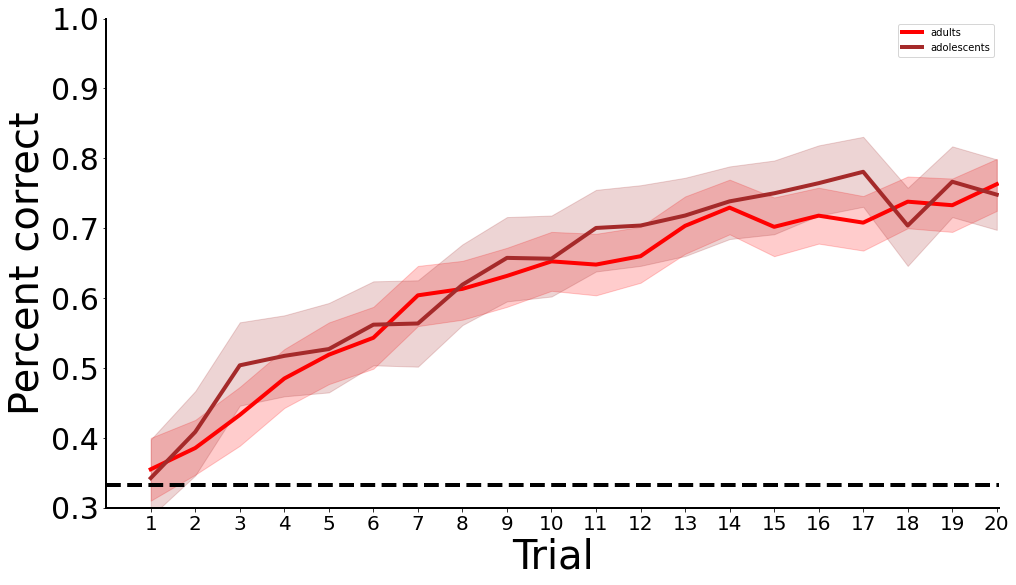

In [13]:
df_adult = pd.melt(adult_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adole = pd.melt(adole_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 3b. Plot age-related number correct in last six

In [14]:
# grab last six games
adult_df_last_6 = getLastSixGames(adult_behav_data, game_length)
adole_df_last_6 = getLastSixGames(adole_behav_data, game_length)

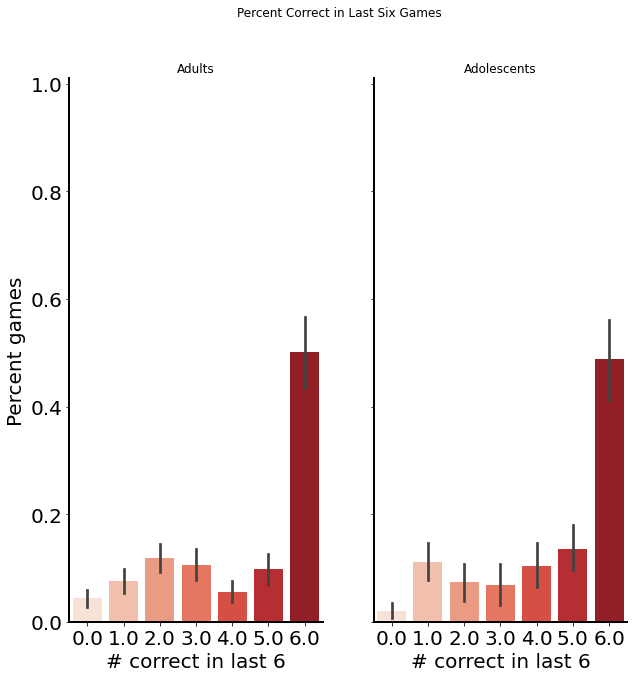

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Percent Correct in Last Six Games')
b1 = sns.barplot(ax = ax1, x="Correct", y="Game", data=adult_df_last_6, palette="Reds",ci=95);
ax1.set_title('Adults')
b2 = sns.barplot(ax = ax2, x="Correct", y="Game", data=adole_df_last_6, palette="Reds",ci=95);
b2.set(ylabel=None)
ax2.set_title('Adolescents')
sns.despine()
ax1.set_ylim([0,1.01])
ax1.set_xlabel('# correct in last 6',fontsize = 20);
ax1.set_ylabel('Percent games',fontsize = 20);
ax2.set_xlabel('# correct in last 6',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)

In [16]:
# separate adults and adolescents in learned vs not learned
learned_adole_df = adole_behav_data.loc[adole_behav_data['LearnedFeat']]
notlearned_adole_df = adole_behav_data.loc[adole_behav_data['LearnedFeat'] == False]

learned_adult_df = adult_behav_data.loc[adult_behav_data['LearnedFeat']]
notlearned_adult_df = adult_behav_data.loc[adult_behav_data['LearnedFeat'] == False]

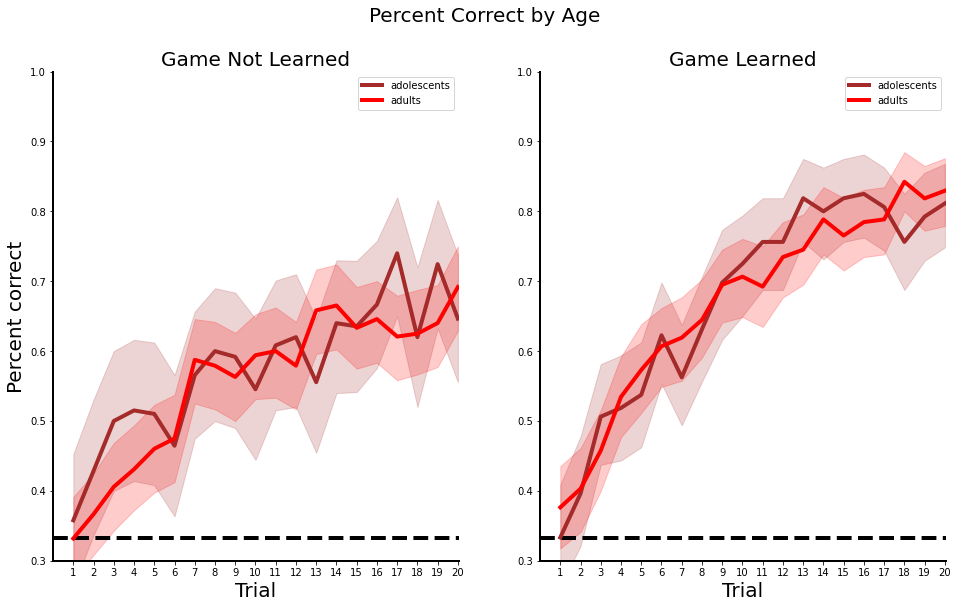

In [17]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Percent Correct by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)
ax1.axhline(y=1/3, color='k', lw=4, linestyle='--');
ax2.axhline(y=1/3, color='k', lw=4, linestyle='--');

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0.3,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0.3, 1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

# Relative Looking Time Analyses

In [18]:
## Define global variables ##
et_data_dir = os.getcwd() + '/ProcessedData/'# this expects ProcessedData to be in the analysis repo
image_dir = os.getcwd().strip('ldm-analysis') + 'FinalStimuli/ByNumber/'
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/' # this expects RawData to be one directory up from the analysis repo

## Define screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 
aoisidelength = 162
n_aois = 9

# Define list with all subject ids; remove 33, 66, and 58 for ec and preproc troubles
good_subjects =  [23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 
                 55, 57, 60, 61, 62, 63, 67, 68, 69, 70, 71];

In [19]:
looking_time_df = {}
for subj_id in good_subjects:
    fixations = pd.read_csv(et_data_dir + str(subj_id) + 'fixations.csv')
    duration_summary = fixations.groupby(['Trial', 'Block','Feature'])['Duration'].sum()
    looking_time_df['Sub' + str(subj_id)] = duration_summary
looking_time_df = pd.DataFrame(looking_time_df).fillna(0).reset_index()

In [20]:
looking_time_df = pd.wide_to_long(looking_time_df, 'Sub', i=['Trial', 'Block', 'Feature'], j="Subj").rename(columns={"Sub": "Duration"}).unstack(level='Feature').reset_index()
# looking_time_df.to_csv(et_data_dir + 'OrganizedLookingTimes.csv')
looking_time_df

Trial Block Subj Duration                                            \
Feature                        1.0    2.0    3.0    4.0    5.0    6.0    7.0   
0          1.0     1   23    0.224  0.904  0.000  0.000  0.568  0.000  1.688   
1          1.0     1   26    0.000  0.000  0.196  0.000  0.208  0.228  2.260   
2          1.0     1   27    0.000  0.000  1.320  0.000  0.028  0.000  0.000   
3          1.0     1   28    1.432  0.000  0.000  0.000  0.268  0.000  0.000   
4          1.0     1   29    0.196  0.000  0.080  0.008  0.156  0.232  1.600   
...        ...   ...  ...      ...    ...    ...    ...    ...    ...    ...   
13995    400.0    10   67    0.400  0.684  0.988  1.260  0.000  0.024  0.000   
13996    400.0    10   68    0.000  0.000  0.000  0.000  0.000  1.237  0.651   
13997    400.0    10   69    0.000  0.000  0.000  0.000  0.000  0.332  0.368   
13998    400.0    10   70    1.180  0.000  0.568  0.000  0.328  1.460  0.000   
13999    400.0    10   71    0.000  0.000  0.016  0.000  0.000  0.000  0.724   

                              
Feature    8.0    9.0   10.0  
0        0.028  0.000  0.364  
1        0.000  0.260  0.420  
2        0.000  2.200  0.236  
3        0.264  1.068  0.784  
4        0.000  0.900  0.100  
...        ...    ...    ...  
13995    0.000  0.000  0.564  
13996    1.695  0.000  0.415  
13997    0.716  2.516  0.032  
13998    0.000  0.000  0.388  
13999    0.720  2.156  0.248  

[14000 rows x 13 columns]

In [21]:
# using to look at chosen features on trials
sub = behav_data.loc[behav_data['Subj'] == 39,['Trial','Chosen1','Chosen2','Chosen3','Feat']]
sub.loc[sub['Trial'] == (9*40)+1]

,Trial,Chosen1,Chosen2,Chosen3,Feat
5560,361,2.0,5.0,9.0,5


In [22]:
for index, row in looking_time_df.iterrows():
    total_looking_time = row.Duration.sum()
    looking_time_df.loc[index, 'TotalLookingTime'] = total_looking_time
looking_time_df.columns = looking_time_df.columns.to_flat_index()
looking_time_df = looking_time_df.rename(columns={('Duration',  1.0): 'Feature1',('Duration',  2.0): 'Feature2', ('Duration',  3.0): 'Feature3',
                        ('Duration',  4.0): 'Feature4',('Duration',  5.0): 'Feature5', ('Duration',  6.0): 'Feature6',
                        ('Duration',  7.0): 'Feature7',('Duration',  8.0): 'Feature8', ('Duration',  9.0): 'Feature9',
                        ('Duration',  10.0): 'Feature10', ('Trial', ''):'Trial', ('Block', ''):'Block',
                        ('Subj', ''):'Subj', ('TotalLookingTime', ''):'TotalLookingTime'})

In [23]:
looking_time_df

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime
0,1.0,1,23,0.224,0.904,0.000,0.000,0.568,0.000,1.688,0.028,0.000,0.364,3.776
1,1.0,1,26,0.000,0.000,0.196,0.000,0.208,0.228,2.260,0.000,0.260,0.420,3.572
2,1.0,1,27,0.000,0.000,1.320,0.000,0.028,0.000,0.000,0.000,2.200,0.236,3.784
3,1.0,1,28,1.432,0.000,0.000,0.000,0.268,0.000,0.000,0.264,1.068,0.784,3.816
4,1.0,1,29,0.196,0.000,0.080,0.008,0.156,0.232,1.600,0.000,0.900,0.100,3.272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,400.0,10,67,0.400,0.684,0.988,1.260,0.000,0.024,0.000,0.000,0.000,0.564,3.920
13996,400.0,10,68,0.000,0.000,0.000,0.000,0.000,1.237,0.651,1.695,0.000,0.415,3.998
13997,400.0,10,69,0.000,0.000,0.000,0.000,0.000,0.332,0.368,0.716,2.516,0.032,3.964
13998,400.0,10,70,1.180,0.000,0.568,0.000,0.328,1.460,0.000,0.000,0.000,0.388,3.924


In [24]:
relative_looking_time_df = looking_time_df
# relative_looking_time_df.columns = looking_time_df.columns.to_flat_index()
# relative_looking_time_df = relative_looking_time_df.rename(columns={('Duration',  1.0): 'Feature1',('Duration',  2.0): 'Feature2', ('Duration',  3.0): 'Feature3',
#                         ('Duration',  4.0): 'Feature4',('Duration',  5.0): 'Feature5', ('Duration',  6.0): 'Feature6',
#                         ('Duration',  7.0): 'Feature7',('Duration',  8.0): 'Feature8', ('Duration',  9.0): 'Feature9',
#                         ('Duration',  10.0): 'Feature10', ('Trial', ''):'Trial', ('Block', ''):'Block',
#                         ('Subj', ''):'Subj', ('TotalLookingTime', ''):'TotalLookingTime'})

In [25]:
for featnum in np.arange(10)+1:
    relative_looking_time_df['Feature'+ str(featnum)] = relative_looking_time_df['Feature'+ str(featnum)]/relative_looking_time_df['TotalLookingTime']
relative_looking_time_df = relative_looking_time_df.drop(columns='TotalLookingTime')

In [26]:
lt_example = looking_time_df.loc[looking_time_df['Subj'] == 39]
lt_example = lt_example.loc[lt_example['Block'] == 10]
lt_example = lt_example.loc[lt_example['Trial'] == (9*40)+1]
lt_example

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime
12612,361.0,10,39,0.0,0.305361,0.065268,0.0,0.002331,0.0,0.0,0.008159,0.455711,0.16317,3.432


In [27]:
lt_example = pd.wide_to_long(lt_example, 'Feature', i=['Trial', 'Block', 'Subj'], j="FeatureNumber")

In [28]:
lt_example.columns = lt_example.columns.to_flat_index()
lt_example = lt_example.reset_index().rename(columns={'Feature':'LookingTime'})

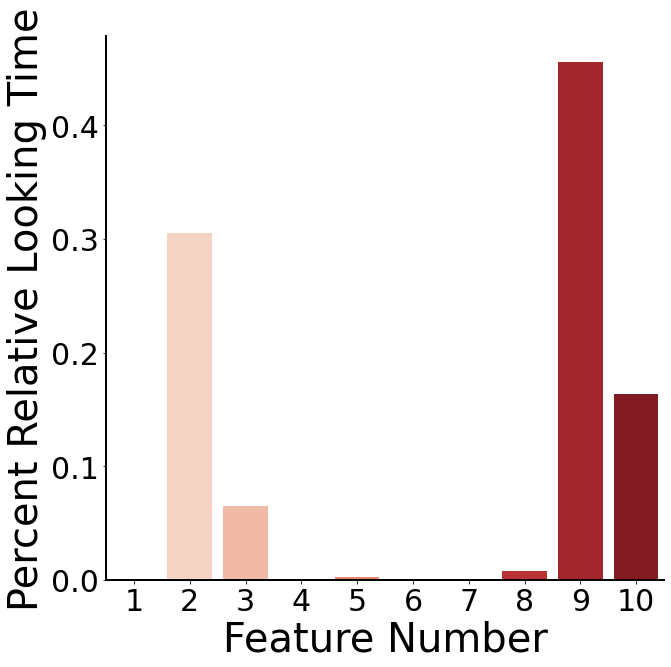

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="FeatureNumber", y="LookingTime", data=lt_example, palette="Reds",ci=95);
sns.despine()
# ax.set_ylim([0,1.01])
xl = ax.set_xlabel('Feature Number',fontsize = 40);
yl = ax.set_ylabel('Percent Relative Looking Time',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)

# Calculate Entropy

In [30]:
len(adult_behav_data)

10000

## Entropy across Features

In [31]:
entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Feature1, row.Feature2, row.Feature3, row.Feature4, row.Feature5, row.Feature6, row.Feature7, row.Feature8, row.Feature9])
    entropy_col.append(curr_entropy)
relative_looking_time_df['FeatureEntropy'] = entropy_col

/usr/local/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


## Entropy Across Dimensions

In [32]:
# sum relative looking time over dimensions
relative_looking_time_df['Animals'] = relative_looking_time_df['Feature1'] + relative_looking_time_df['Feature2'] + relative_looking_time_df['Feature3']
relative_looking_time_df['Landscapes'] = relative_looking_time_df['Feature4'] + relative_looking_time_df['Feature5'] + relative_looking_time_df['Feature6']
relative_looking_time_df['Objects'] = relative_looking_time_df['Feature7'] + relative_looking_time_df['Feature8'] + relative_looking_time_df['Feature9']

entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Animals, row.Landscapes, row.Objects])
    entropy_col.append(curr_entropy)
relative_looking_time_df['DimensionEntropy'] = entropy_col

In [33]:
relative_looking_time_df

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,1.0,1,23,0.059322,0.239407,0.000000,0.000000,0.150424,0.000000,0.447034,0.007415,0.000000,0.096398,1.216753,0.298729,0.150424,0.454449,1.010061
1,1.0,1,26,0.000000,0.000000,0.054871,0.000000,0.058231,0.063830,0.632699,0.000000,0.072788,0.117581,0.986428,0.054871,0.122060,0.705487,0.625260
2,1.0,1,27,0.000000,0.000000,0.348837,0.000000,0.007400,0.000000,0.000000,0.000000,0.581395,0.062368,0.702414,0.348837,0.007400,0.581395,0.702414
3,1.0,1,28,0.375262,0.000000,0.000000,0.000000,0.070231,0.000000,0.000000,0.069182,0.279874,0.205451,1.148813,0.375262,0.070231,0.349057,0.930081
4,1.0,1,29,0.059902,0.000000,0.024450,0.002445,0.047677,0.070905,0.488998,0.000000,0.275061,0.030562,1.321986,0.084352,0.121027,0.764059,0.659852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,400.0,10,67,0.102041,0.174490,0.252041,0.321429,0.000000,0.006122,0.000000,0.000000,0.000000,0.143878,1.340827,0.528571,0.327551,0.000000,0.665322
13996,400.0,10,68,0.000000,0.000000,0.000000,0.000000,0.000000,0.309405,0.162831,0.423962,0.000000,0.103802,1.031132,0.000000,0.309405,0.586793,0.644451
13997,400.0,10,69,0.000000,0.000000,0.000000,0.000000,0.000000,0.083754,0.092836,0.180626,0.634712,0.008073,1.026246,0.000000,0.083754,0.908174,0.289471
13998,400.0,10,70,0.300714,0.000000,0.144750,0.000000,0.083588,0.372069,0.000000,0.000000,0.000000,0.098879,1.245771,0.445464,0.455657,0.000000,0.693083


# Make one big DF

In [34]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)

In [35]:
new_df = pd.merge(good_behav_data, relative_looking_time_df,  how='left', on=['Subj','Trial'])

In [36]:
new_df

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,23,1,1,1,6,8,2,5,7,3,...,0.000000,0.447034,0.007415,0.000000,0.096398,1.216753,0.298729,0.150424,0.454449,1.010061
1,23,2,1,2,5,7,1,4,8,3,...,0.000000,0.138427,0.197121,0.000000,0.019934,1.456030,0.212625,0.431894,0.335548,1.059602
2,23,3,1,3,4,7,2,5,9,1,...,0.000000,0.405690,0.000000,0.242360,0.011591,1.423608,0.144362,0.195996,0.648051,0.878586
3,23,4,1,1,4,7,2,5,8,3,...,0.000000,0.000000,0.487912,0.000000,0.025275,0.976750,0.362637,0.124176,0.487912,0.976750
4,23,5,1,1,6,8,2,4,7,3,...,0.000000,0.439220,0.000000,0.042431,0.017202,1.223997,0.243119,0.258028,0.481651,1.046173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,71,396,20,1,5,7,3,4,9,2,...,0.158747,0.109071,0.000000,0.490281,0.021598,1.301337,0.208423,0.170626,0.599352,0.934187
13996,71,397,20,1,5,8,2,4,9,3,...,0.000000,0.000000,0.000000,0.593079,0.056086,0.904914,0.130072,0.220764,0.593079,0.904914
13997,71,398,20,1,6,7,2,4,9,3,...,0.000000,0.000000,0.124040,0.403952,0.027442,1.323462,0.416026,0.028540,0.527991,0.798422
13998,71,399,20,1,6,7,3,5,8,2,...,0.036677,0.354908,0.266451,0.001079,0.019417,1.518259,0.166127,0.192017,0.622438,0.908579


In [37]:
adole_combined_df = new_df[new_df['Adult'] == False]
adult_combined_df = new_df[new_df['Adult']]

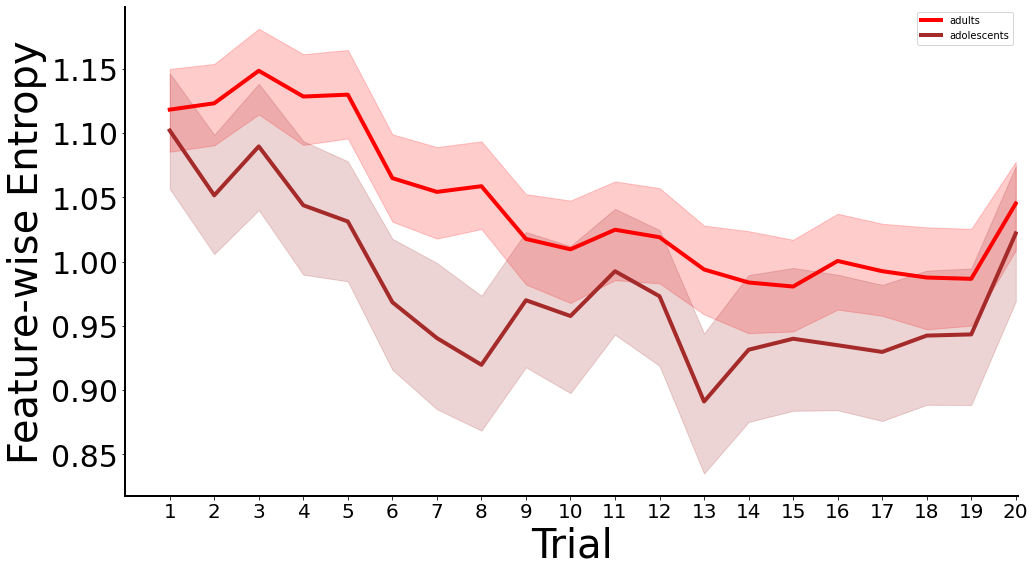

In [38]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Feature-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

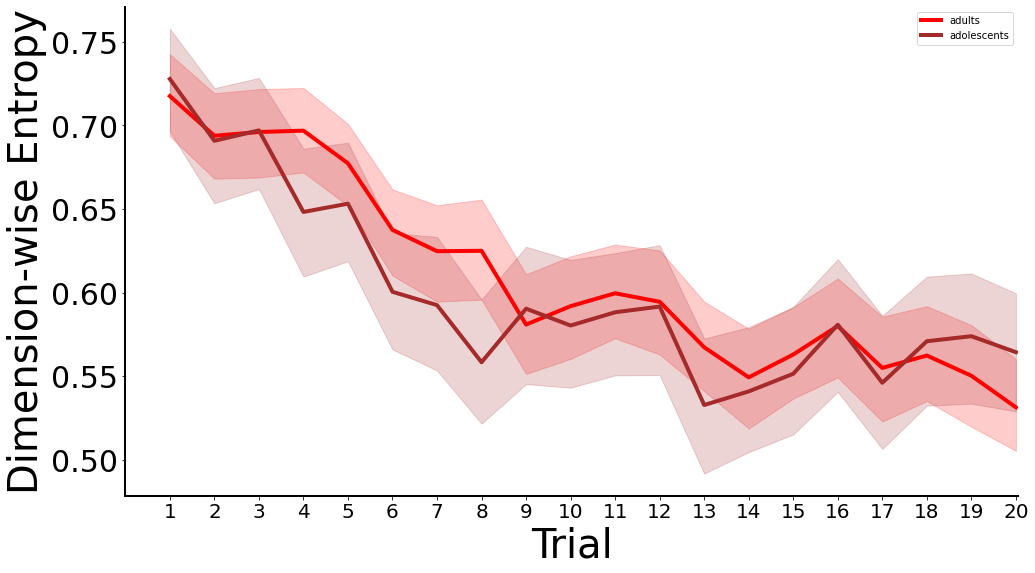

In [39]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Dimension-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

In [40]:
# separate adults and adolescents in learned vs not learned
learned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat']]
notlearned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat'] == False]

learned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat']]
notlearned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat'] == False]

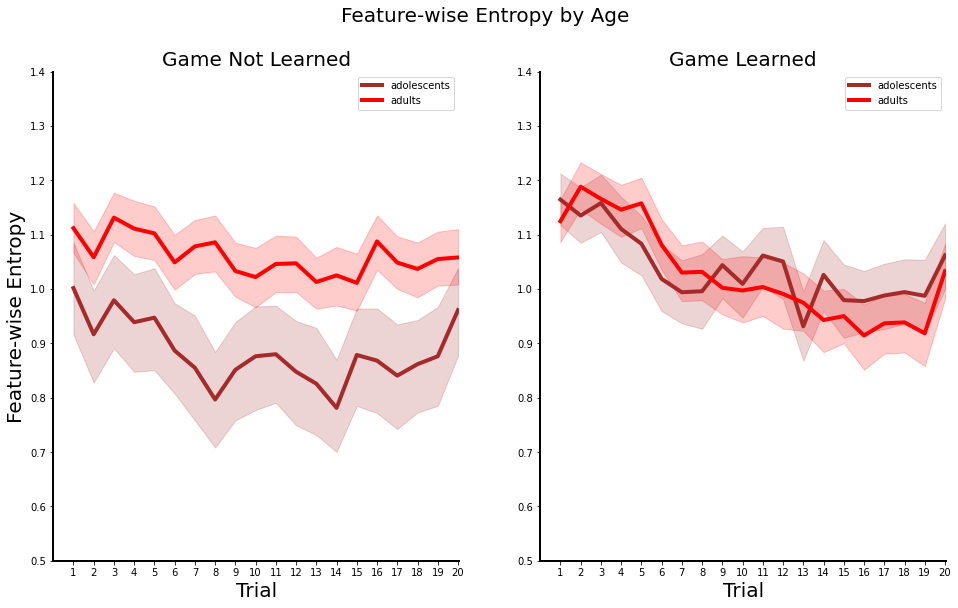

In [42]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Feature-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0.5,1.4])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0.5,1.4])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

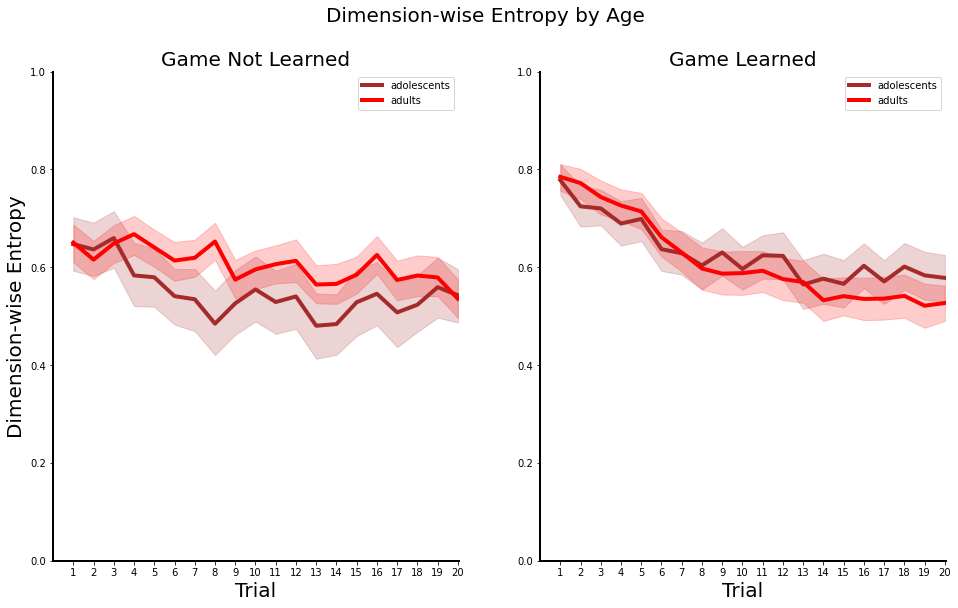

In [44]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Dimension-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0,1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

# Look across Games

In [45]:
new_df

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,23,1,1,1,6,8,2,5,7,3,...,0.000000,0.447034,0.007415,0.000000,0.096398,1.216753,0.298729,0.150424,0.454449,1.010061
1,23,2,1,2,5,7,1,4,8,3,...,0.000000,0.138427,0.197121,0.000000,0.019934,1.456030,0.212625,0.431894,0.335548,1.059602
2,23,3,1,3,4,7,2,5,9,1,...,0.000000,0.405690,0.000000,0.242360,0.011591,1.423608,0.144362,0.195996,0.648051,0.878586
3,23,4,1,1,4,7,2,5,8,3,...,0.000000,0.000000,0.487912,0.000000,0.025275,0.976750,0.362637,0.124176,0.487912,0.976750
4,23,5,1,1,6,8,2,4,7,3,...,0.000000,0.439220,0.000000,0.042431,0.017202,1.223997,0.243119,0.258028,0.481651,1.046173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,71,396,20,1,5,7,3,4,9,2,...,0.158747,0.109071,0.000000,0.490281,0.021598,1.301337,0.208423,0.170626,0.599352,0.934187
13996,71,397,20,1,5,8,2,4,9,3,...,0.000000,0.000000,0.000000,0.593079,0.056086,0.904914,0.130072,0.220764,0.593079,0.904914
13997,71,398,20,1,6,7,2,4,9,3,...,0.000000,0.000000,0.124040,0.403952,0.027442,1.323462,0.416026,0.028540,0.527991,0.798422
13998,71,399,20,1,6,7,3,5,8,2,...,0.036677,0.354908,0.266451,0.001079,0.019417,1.518259,0.166127,0.192017,0.622438,0.908579


In [ ]:
adole_combined_df
adult_combined_df

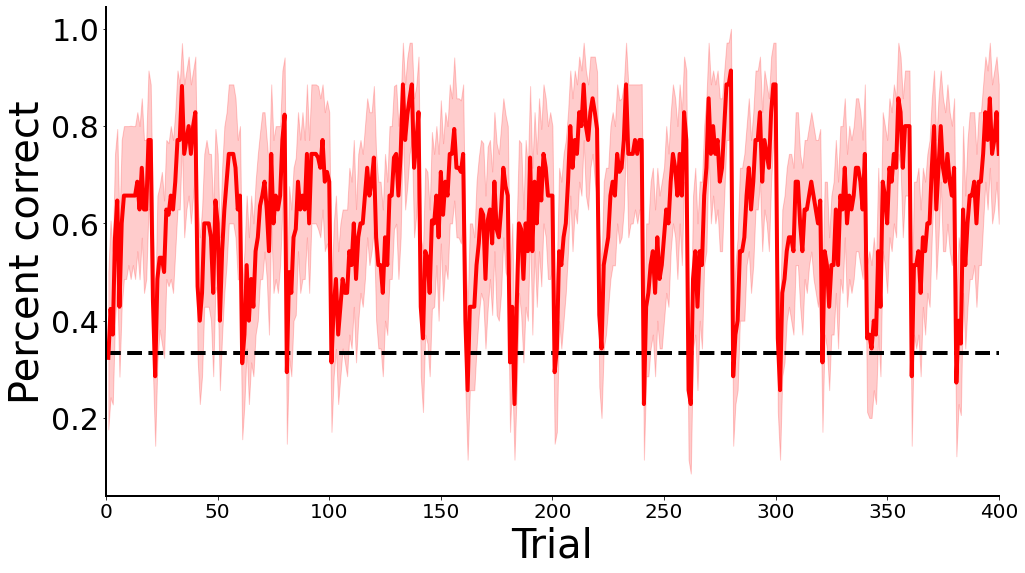

In [48]:
df = pd.melt(new_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='red')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(400)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

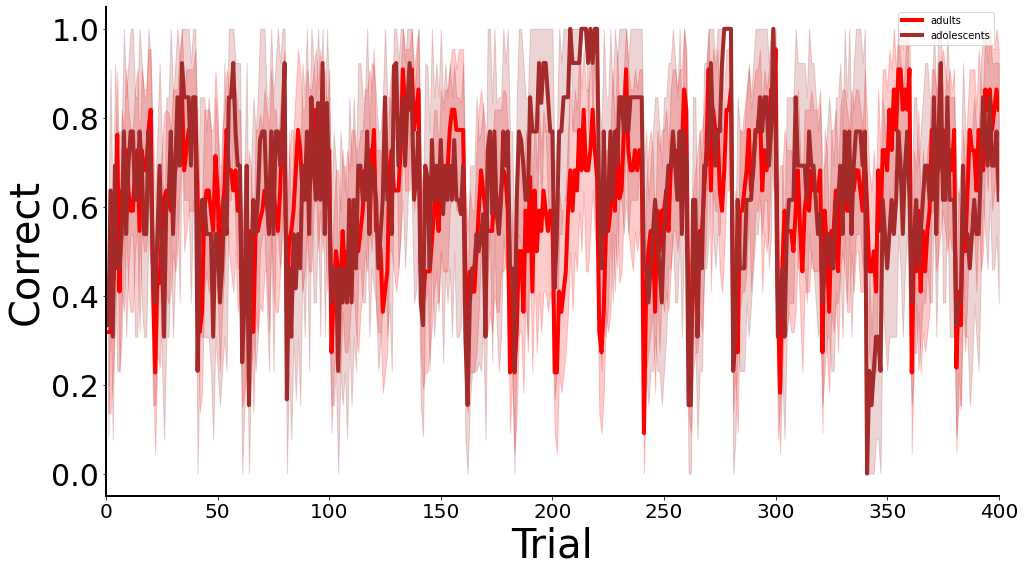

In [54]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

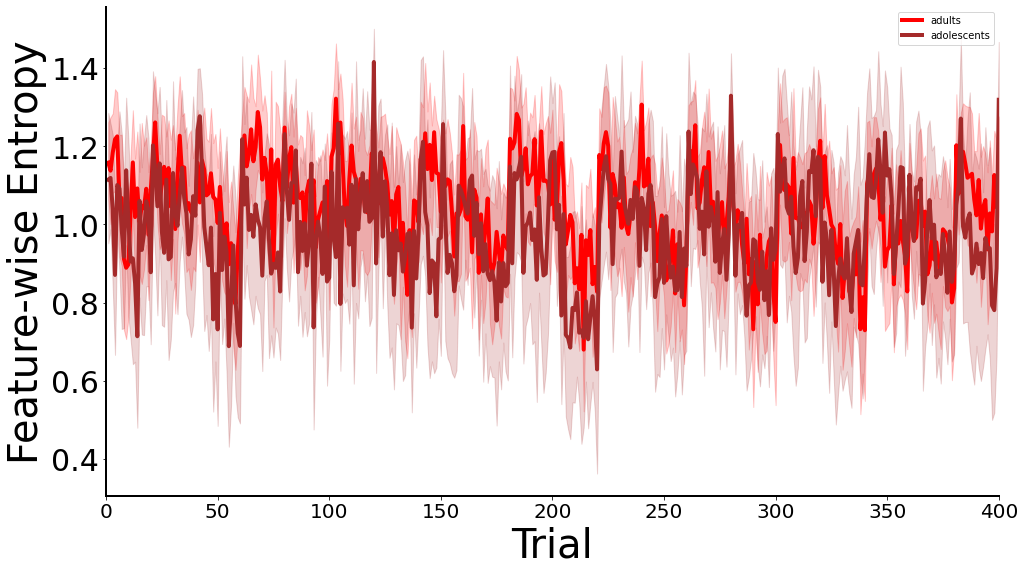

In [55]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Feature-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

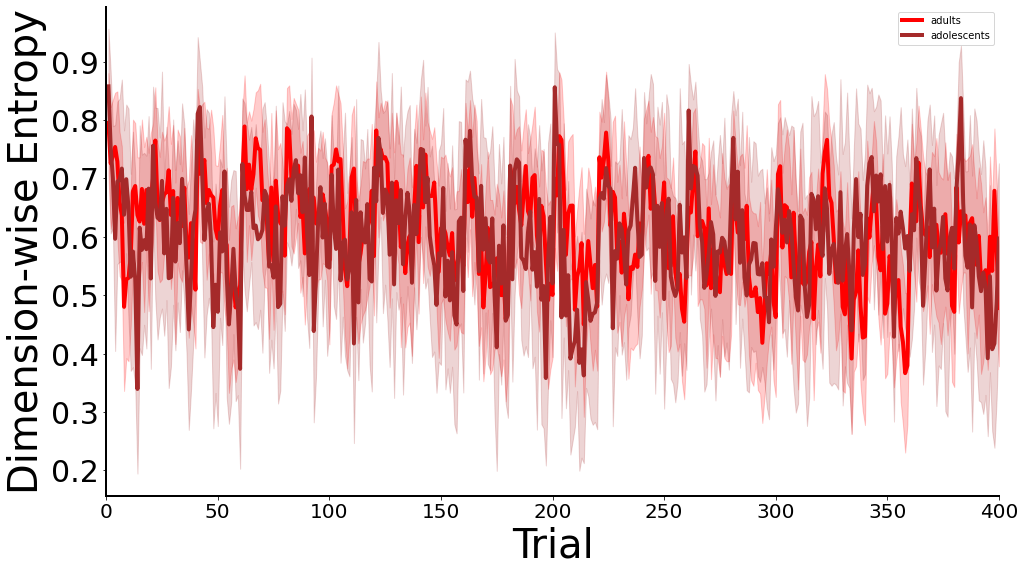

In [56]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Dimension-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

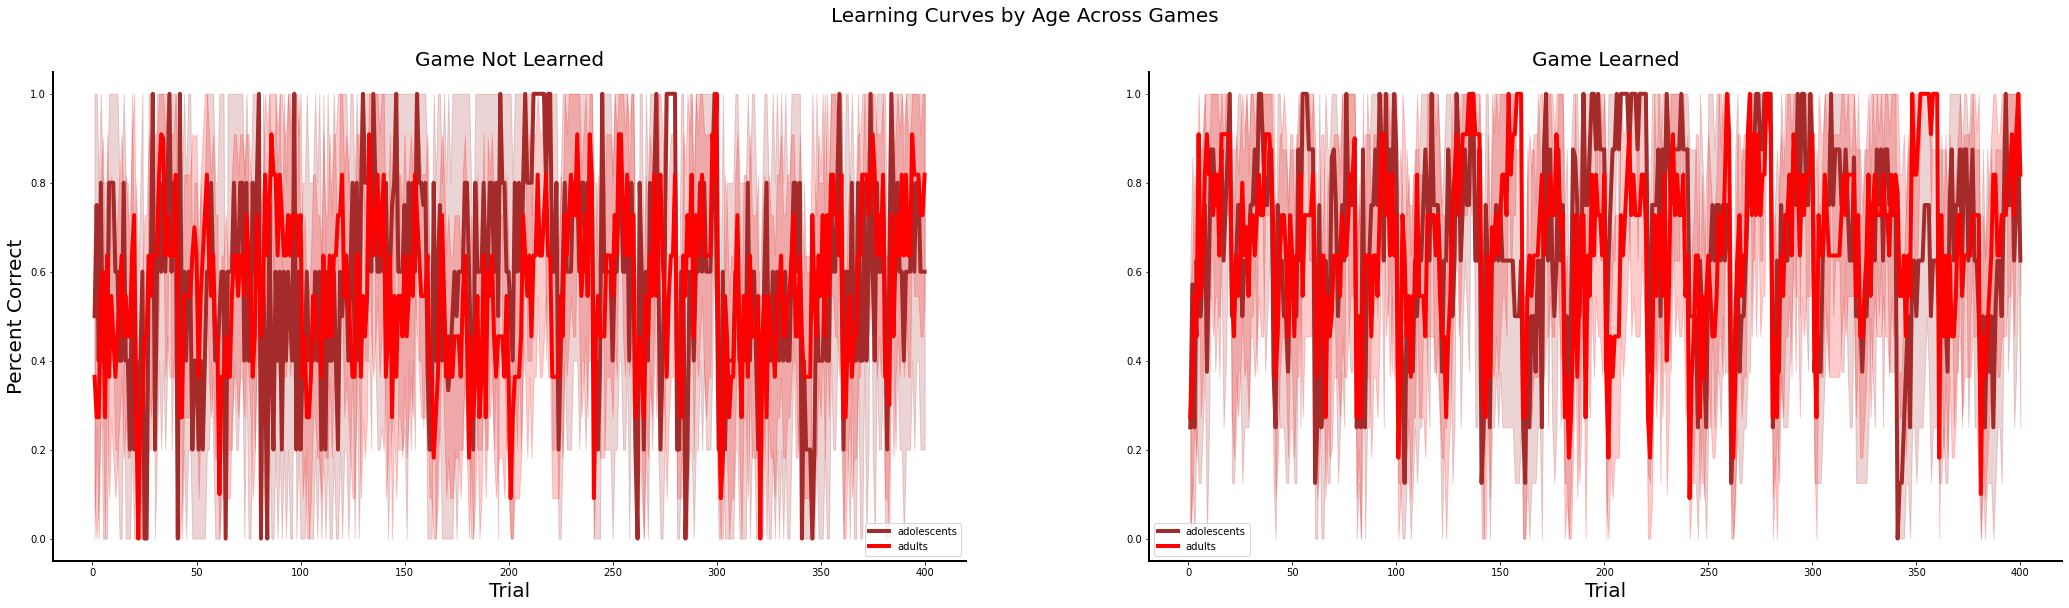

In [61]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Learning Curves by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# # ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([-0.5,1.5])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax1.set_ylim([-0.5,1.5])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent Correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

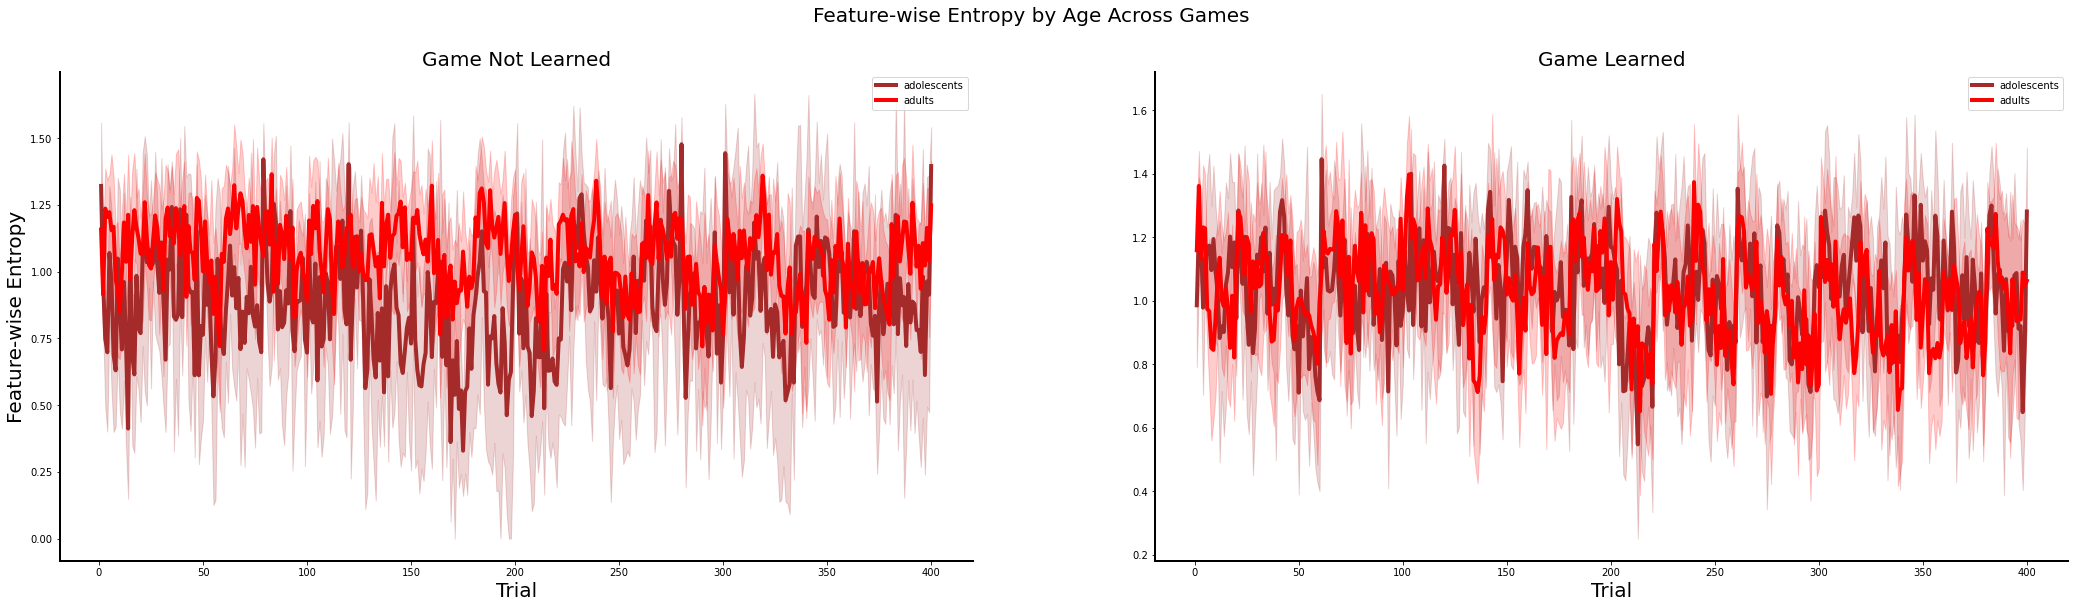

In [60]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Feature-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

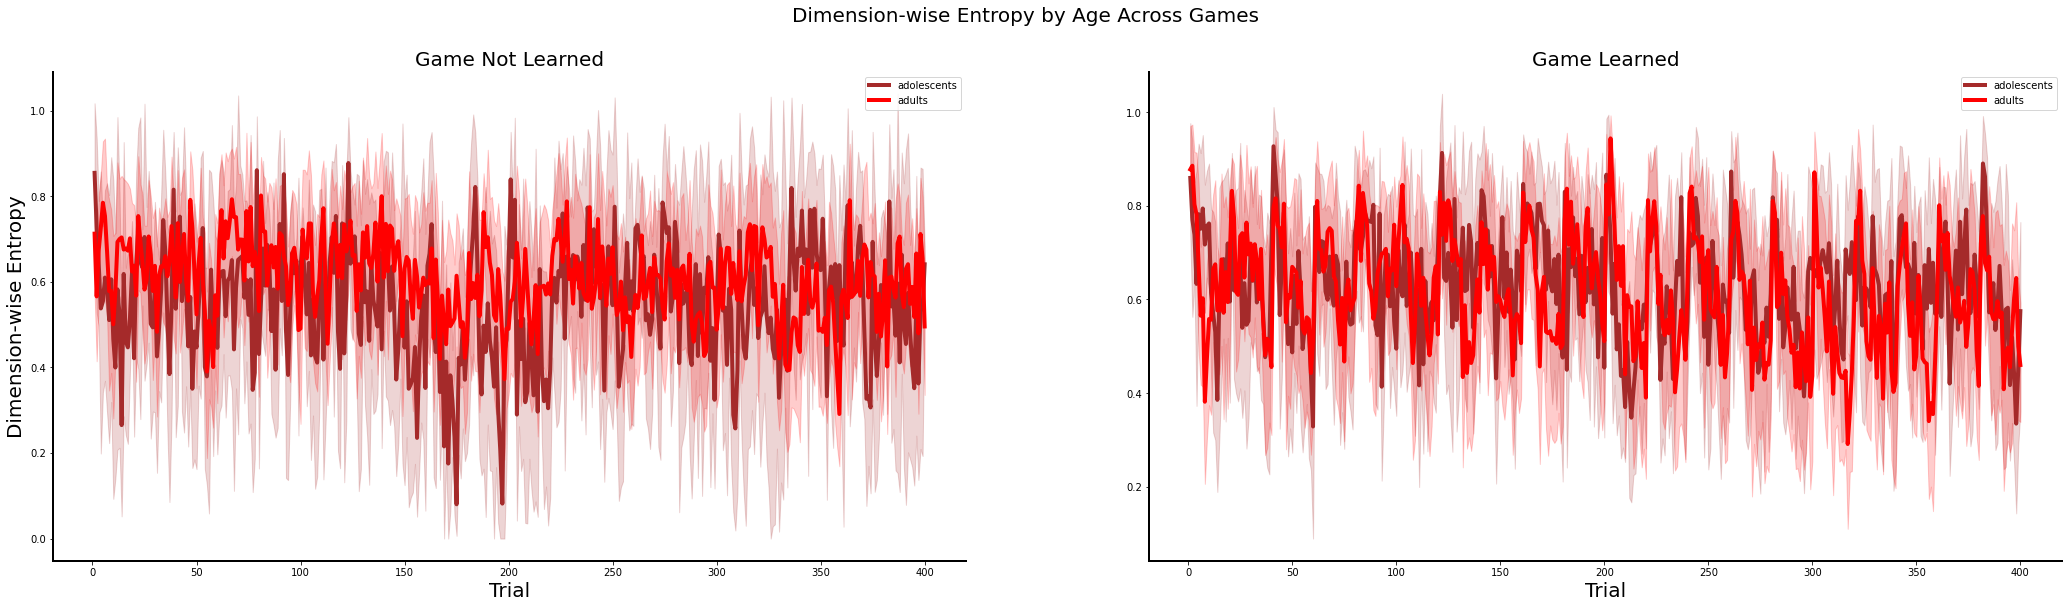

In [62]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Dimension-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')